In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pylab

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from deepclean.signal import filter
from deepclean.architectures import my_convolutional_autoencoder

from deepclean.trainer import criterion
from deepclean.trainer import dataloader

from mymodule import fit
from mymodule import evaluate_history
from mymodule import torch_seed


In [2]:
sample_rate = 4096

freq_low = 50
freq_high = 70
order = 8
bandpass_filter = filter.BandpassFilter(freq_low, freq_high, sample_rate, order)

data2_train = np.load("p60_train.npy")
data2_train = (data2_train - data2_train.mean())/data2_train.std()
data2 = data2_train
#data2_train = bandpass_filter(data2_train)
data2_train = data2_train.reshape((1, len(data2_train)))

strain_train = np.load("Lp60_train.npy")
strain_train = bandpass_filter(strain_train)
strain_train = (strain_train - strain_train.mean())/strain_train.std()

dataset_train = dataloader.ChunkedTimeSeriesDataset(data2_train,
                                              strain_train,
                                              kernel_length=8,
                                              kernel_stride=0.25,
                                              sample_rate=4096,
                                              batch_size=10,
                                              shuffle=False,
                                              chunk_length=-1,
                                              device="cuda:0")

print(dataset_train.X.shape)

data2_test = np.load("p60_test.npy")

data2_test = (data2_test - data2_test.mean())/data2_test.std()
#data2_test = bandpass_filter(data2_test)
data2_test = data2_test.reshape((1, len(data2_test)))


strain_test = np.load("Lp60_test.npy")

strain_test = bandpass_filter(strain_test)
strain_test = (strain_test - strain_test.mean())/strain_test.std()

dataset_test = dataloader.ChunkedTimeSeriesDataset(data2_test,
                                              strain_test,
                                              kernel_length=8,
                                              kernel_stride=4,
                                              sample_rate=4096,
                                              batch_size=5,
                                              chunk_length=-1,
                                              shuffle=False,
                                              device="cuda:0")

print(dataset_test.X.shape)

torch.manual_seed(1)

torch.Size([11969, 1, 32768])
torch.Size([749, 1, 32768])


torch.Size([16385, 749])


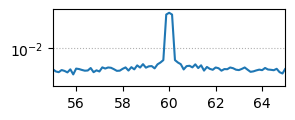

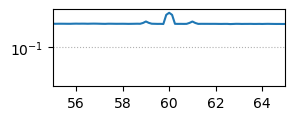

In [3]:
segment_times = 8
sample_rate = 4096
overlap_times = 4
ylim = [1e3, 1e4]
xlim = [55, 65]

nperseg = int(segment_times * sample_rate)
nstride = nperseg - overlap_times * sample_rate
window = torch.hann_window(nperseg).to("cpu")

witness1 = torch.tensor(data2)
strain = torch.tensor(strain_train)

witness1_asd = torch.stft(witness1, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
print(witness1_asd.shape)
witness1_asd = torch.mean(witness1_asd, 1)
strain_asd = torch.stft(strain, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
strain_asd = torch.mean(strain_asd, 1)

freq = np.arange(0, 2048+(1/segment_times), (1/segment_times))

pylab.figure(figsize=(3, 1))
pylab.plot(freq, witness1_asd)
#pylab.ylim(ylim[0], ylim[1])
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(3, 1))
pylab.plot(freq, strain_asd)
#pylab.ylim(ylim[0], ylim[1])
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

In [4]:
num_witness = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    
lr = 0.00001
#net = CNN(num_witness).to(device)
net = my_convolutional_autoencoder.DeepCleanAE(1).to(device)
#criterion = CustomLoss()
loss = criterion.CompositePSDLoss(alpha=1, 
                                  sample_rate=4096, 
                                  fftlength=4, 
                                  freq_low=55,
                                  freq_high=65,
                                  device="cuda:0")

optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1)
history = np.zeros((0,3))
print(history.shape)

cuda:0
(0, 3)


In [5]:
num_epochs = 10
history = fit(net, optimizer, loss, 0.5,  num_epochs, dataset_train, dataset_test, device, history, scheduler)

Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.09371  val_loss: 0.18699
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.09322  val_loss: 0.18643
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.09298  val_loss: 0.18601
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.09280  val_loss: 0.18571
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.09268  val_loss: 0.18550
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.09260  val_loss: 0.18539
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.09256  val_loss: 0.18534
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.09255  val_loss: 0.18533
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.09254  val_loss: 0.18532
Learning_Rate = [1e-05]


  0%|          | 0/1197 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.09254  val_loss: 0.18532


初期状態: 損失: 0.09371 精度: 0.18699
最終状態: 損失: 0.09254 精度: 0.18532


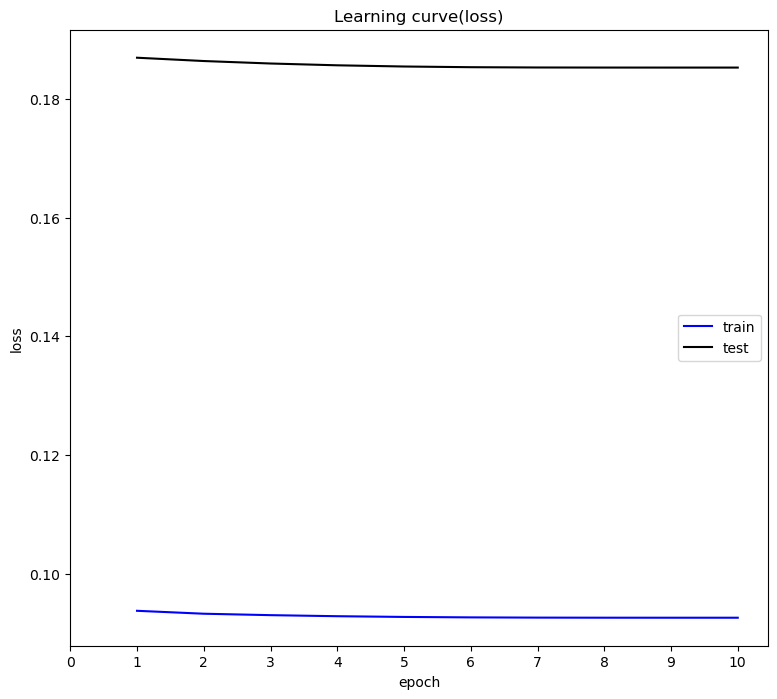

In [6]:
evaluate_history(history)

  0%|          | 0/150 [00:00<?, ?it/s]

'\nL_matrix_test  = np.load("/home/k-takatani/npy_data/L_matrix_test.npy")\nL_tensor_test = torch.tensor(L_matrix_test)\nL_tensor_test = L_tensor_test.reshape(1048576)\n\nfreq = np.arange(0, 2048.125, 0.125)\n\npylab.figure()\npylab.loglog(freq, L_asd)\npylab.xlim(15, 2048)\n'

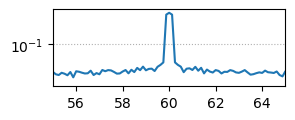

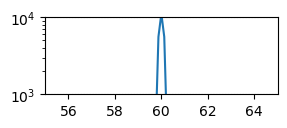

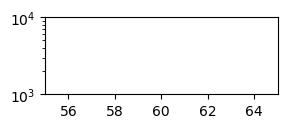

In [7]:
witness1 = []
witness2 = []
strain = []
output_array = []

kernel_stride = 4
sample_rate = 4096
fft_length = 8
overlap_times = 4

overlap_samples = kernel_stride *sample_rate

nperseg = int(fft_length * sample_rate)
nstride = nperseg - overlap_times * sample_rate
window = torch.hann_window(nperseg).to("cpu")

initial_input = True
initial_target = True
initial_output = True

net.eval()

for inputs1, targets in tqdm(dataset_test):
    input_batches = inputs1.squeeze(1)
    #inputs_bathcesはwitnessの復元、inputsはoutputsを出すために使われる。
    inputs = inputs1.to(device)
    outputs = net(inputs).to("cpu").detach()

    for input in input_batches:
        if initial_input:
            witness1 = np.append(witness1, input.to("cpu"))
            initial_input = False
        else:
            #datasetでoverlapさせているので戻す。
            witness1 = np.append(witness1, input[overlap_samples:].to("cpu"))

    for target in targets:
        if initial_target:
            strain = np.append(strain, target.to("cpu"))
            initial_target = False
        else:
            strain = np.append(strain, target[overlap_samples:].to("cpu"))

    for output in outputs:
        if initial_output:
            output_array = np.append(output_array, output.to("cpu"))
            initial_output = False         
        else:
            output_array = np.append(output_array, output[overlap_samples:].to("cpu"))
            
subtracted = strain - output_array

witness1 = torch.tensor(witness1)
strain = torch.tensor(strain)
subtracted = torch.tensor(subtracted)

witness1_asd = torch.stft(witness1, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
witness1_asd = torch.mean(witness1_asd, 1)
strain_asd = torch.stft(strain, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
strain_asd = torch.mean(strain_asd, 1)
subtracted_asd = torch.stft(subtracted, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
subtracted_asd = torch.mean(subtracted_asd, 1)

freq = np.arange(0, 2048+(1/segment_times), (1/segment_times))

pylab.figure(figsize=(3, 1))
pylab.plot(freq, witness1_asd)
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(3, 1))
pylab.plot(freq, strain_asd)
pylab.ylim(ylim[0], ylim[1])
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(3, 1))
pylab.plot(freq, subtracted_asd)
pylab.ylim(ylim[0], ylim[1])
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

"""
L_matrix_test  = np.load("/home/k-takatani/npy_data/L_matrix_test.npy")
L_tensor_test = torch.tensor(L_matrix_test)
L_tensor_test = L_tensor_test.reshape(1048576)

freq = np.arange(0, 2048.125, 0.125)

pylab.figure()
pylab.loglog(freq, L_asd)
pylab.xlim(15, 2048)
"""

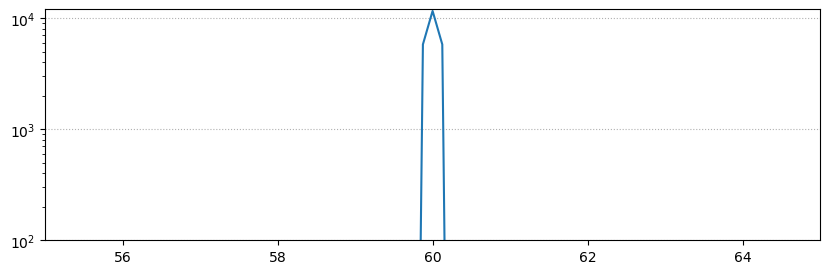

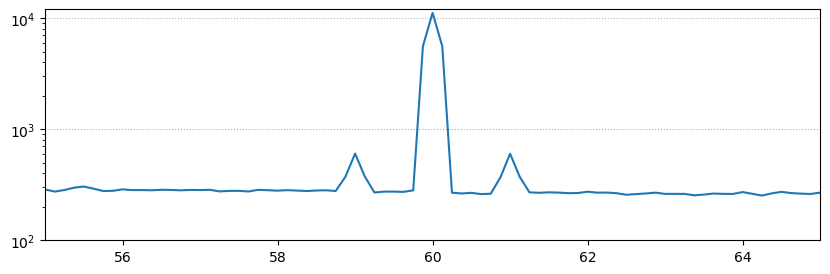

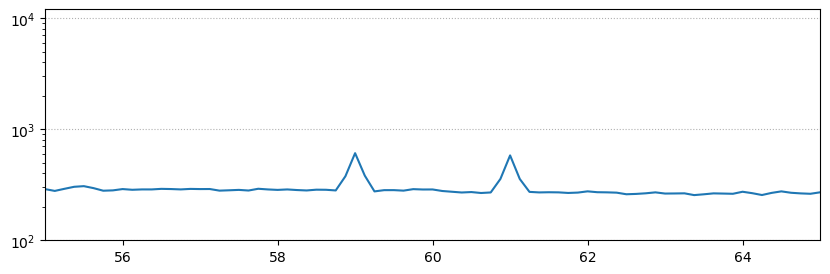

In [11]:
xlim = [55, 65]
ylim = [1e2, 1.2*1e4]

pylab.figure(figsize=(10, 3))
pylab.plot(freq, witness1_asd)
pylab.xlim(xlim[0], xlim[1])
pylab.ylim(ylim[0], ylim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(10, 3))
pylab.plot(freq, strain_asd)
pylab.ylim(ylim[0], ylim[1])
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(10, 3))
pylab.plot(freq, subtracted_asd)
pylab.ylim(ylim[0], ylim[1])
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')


  0%|          | 0/75 [00:00<?, ?it/s]

(12288000,)
torch.Size([16385])


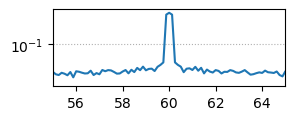

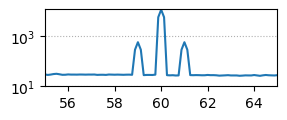

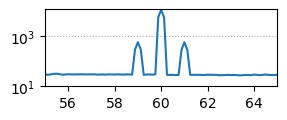

In [7]:
witness1 = []
witness2 = []
strain = []
output_array = []

segment_times = 8
sample_rate = 4096
overlap_times = 4
xlim = [55, 65]
ylim = [1e1, 1.2*1e4]

nperseg = int(segment_times * sample_rate)
nstride = nperseg - overlap_times * sample_rate
window = torch.hann_window(nperseg).to("cpu")

net.eval()

for inputs1, targets in tqdm(dataset_test):
    inputs = inputs1.to(device)
    #targets = targets.to(device)
    outputs = net(inputs).to("cpu").detach()

    witness1 = np.append(witness1, inputs1.to("cpu"))
    strain = np.append(strain, targets.to("cpu"))
    output_array = np.append(output_array, outputs)
print(witness1.shape)

witness1 = torch.tensor(witness1)
strain = torch.tensor(strain)
output_array = torch.tensor(output_array)


subtracted = strain - output_array

#strain = (strain * 7.032336114823923e-22) + 2.1915200354877797e-24
#subtracted = (subtracted * 7.032336114823923e-22) + 2.1915200354877797e-24

witness1_asd = torch.stft(witness1, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
witness1_asd = torch.mean(witness1_asd, 1)
strain_asd = torch.stft(strain, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
strain_asd = torch.mean(strain_asd, 1)
subtracted_asd = torch.stft(subtracted, n_fft=nperseg, hop_length=nstride,window=window, normalized=False, center=False, return_complex=True).abs()
subtracted_asd = torch.mean(subtracted_asd, 1)

print(witness1_asd.shape)

#witness1_asd = asd_from_array(witness1, segment_times=segment_times)
#strain_asd = asd_from_array(strain, segment_times=segment_times)
#subtracted_asd = asd_from_array(subtracted, segment_times=segment_times)

freq = np.arange(0, 2048+(1/segment_times), (1/segment_times))

pylab.figure(figsize=(3, 1))
pylab.plot(freq, witness1_asd)
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(3, 1))
pylab.plot(freq, strain_asd)
pylab.ylim(ylim[0], ylim[1])
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

pylab.figure(figsize=(3, 1))
pylab.plot(freq, subtracted_asd)
pylab.ylim(ylim[0], ylim[1])
pylab.xlim(xlim[0], xlim[1])
pylab.yscale("log")
pylab.grid(which='major',axis='y' ,linestyle='dotted')

L_matrix_test  = np.load("/home/k-takatani/npy_data/L_matrix_test.npy")
L_tensor_test = torch.tensor(L_matrix_test)
L_tensor_test = L_tensor_test.reshape(1048576)

#L_asd = (asd_from_array(L_tensor_test, segment_times=8) * 6.0583398864160925e-22) + 2.191562086858314e-24
#print(L_asd.shape)

freq = np.arange(0, 2048.125, 0.125)

#pylab.figure()
#pylab.loglog(freq, L_asd)
#pylab.xlim(15, 2048)

In [8]:
#coading_Test

witness1 = []
witness2 = []
strain = []
output_array = []

kernel_stride = 4
sample_rate = 4096

overlap_samples = kernel_stride *sample_rate

initial = True

for inputs1, targets in tqdm(dataset_test):
    input_batches = inputs1.squeeze(1)
    for input in input_batches:
        if initial:
            print(input.shape)

            witness1 = np.append(witness1, input.to("cpu"))
            initial = False
            print("witness", witness1.shape)
             
        else:
            #datasetでoverlapさせているので戻す。
            witness1 = np.append(witness1, input[overlap_samples:].to("cpu"))
        
            print("input", input[overlap_samples:].shape)
            print("witness", witness1.shape)
    

test = data2_test - witness1


  0%|          | 0/75 [00:00<?, ?it/s]

torch.Size([32768])
witness (32768,)
torch.Size([32768])
witness (65536,)
torch.Size([32768])
witness (98304,)
torch.Size([32768])
witness (131072,)
torch.Size([32768])
witness (163840,)
torch.Size([32768])
witness (196608,)
torch.Size([32768])
witness (229376,)
torch.Size([32768])
witness (262144,)
torch.Size([32768])
witness (294912,)
torch.Size([32768])
witness (327680,)
torch.Size([32768])
witness (360448,)
torch.Size([32768])
witness (393216,)
torch.Size([32768])
witness (425984,)
torch.Size([32768])
witness (458752,)
torch.Size([32768])
witness (491520,)
torch.Size([32768])
witness (524288,)
torch.Size([32768])
witness (557056,)
torch.Size([32768])
witness (589824,)
torch.Size([32768])
witness (622592,)
torch.Size([32768])
witness (655360,)
torch.Size([32768])
witness (688128,)
torch.Size([32768])
witness (720896,)
torch.Size([32768])
witness (753664,)
torch.Size([32768])
witness (786432,)
torch.Size([32768])
witness (819200,)
torch.Size([32768])
witness (851968,)
torch.Size([327

In [61]:
print(test.shape)

(1, 12288000)


(32000.0, 33000.0)

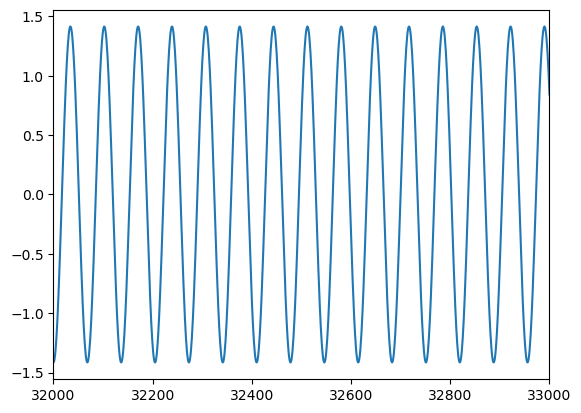

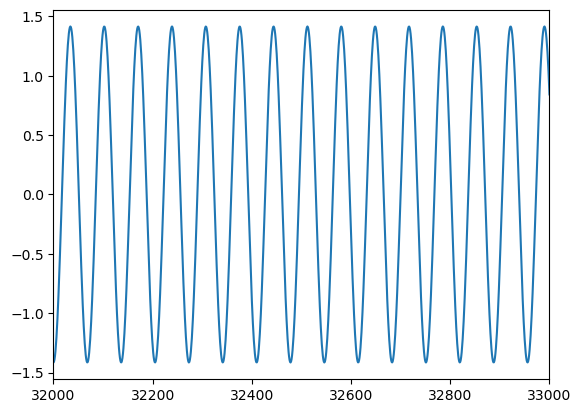

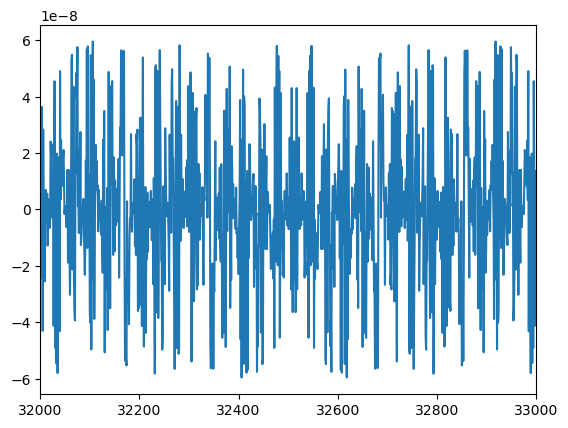

In [13]:
l = 32000
r = 33000

times = np.linspace(0, test.shape[1], test.shape[1])

pylab.plot(times, data2_test[0, :])
pylab.xlim(l, r)

pylab.figure()
pylab.plot(times, witness1)
pylab.xlim(l, r)

pylab.figure()
pylab.plot(times, test[0,:])
pylab.xlim(l, r)

(array([4000., 4200., 4400., 4600., 4800., 5000.]),
 [Text(4000.0, 0, '4000'),
  Text(4200.0, 0, '4200'),
  Text(4400.0, 0, '4400'),
  Text(4600.0, 0, '4600'),
  Text(4800.0, 0, '4800'),
  Text(5000.0, 0, '5000')])

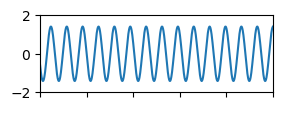

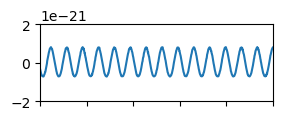

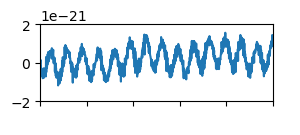

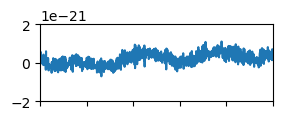

In [11]:
strain_t = strain
output_array_t = output_array
for inputs1, targets in test_loader:
    inputs = inputs1.to(device)
    #targets = targets.to(device)
    outputs = net(inputs).to("cpu").detach()

    witness1 = np.append(witness1, inputs1)
    strain_t = np.append(strain_t, targets)
    output_array_t = np.append(output_array_t, outputs)
subtracted = strain_t - output_array_t

output_array_t = (output_array_t * 7.032336114823923e-22) 
strain_t = (strain_t * 7.032336114823923e-22) 
subtracted = (subtracted * 7.032336114823923e-22) + 2.1915200354877797e-24

times = np.arange(0, len(witness1))

pylab.figure(figsize=(3, 1))
pylab.plot(times, witness1)
pylab.xlim(4000, 5000)
pylab.ylim(-2., 2.)
pylab.xticks(color="None")
#pylab.yticks(color="None")

times = np.arange(0, len(strain_t))

pylab.figure(figsize=(3, 1))
pylab.plot(times, output_array_t)
pylab.xlim(4000, 5000)
pylab.ylim(-2.e-21, 2.e-21)
pylab.xticks(color="None")
#pylab.yticks(color="None")

pylab.figure(figsize=(3, 1))
pylab.plot(times, strain_t)
pylab.xlim(4000, 5000)
pylab.ylim(-2.e-21, 2.e-21)
pylab.xticks(color="None")
#pylab.yticks(color="None")

pylab.figure(figsize=(3, 1))
pylab.plot(times, subtracted)
pylab.xlim(4000,5000)
pylab.ylim(-2.e-21, 2.e-21)
pylab.xticks(color="None")
#pylab.yticks(color="None")


In [41]:
freq = np.arange(0, 4097)
times = np.arange(0, len(targets[0]))

for i in range(0, 3):
    outputs = net(inputs)
    target = targets[i]
    subtracted = target - outputs[i]
    subtracted = subtracted

    s = target
    
    #h_asd = h.psd(0.1) **(1/2) * L_std
    
    s_sub = subtracted 
        
    s = s.to("cpu").detach()
    s_sub = s_sub.to("cpu").detach()
    
    pylab.figure()
    pylab.title("strain")
    pylab.plot(times, s)
#    pylab.ylim(1e-3, 1e-1)
 #   pylab.loglog(freq, s_asd)
    pylab.figure()
    pylab.title("subtracted")
    pylab.plot(times, s_sub)
  #  pylab.ylim(1e-3, 1e-1)
   # pylab.loglog(freq, s_sub_asd)

    

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
L_tensor = torch.tensor(L_matrix, dtype=torch.float32)
g_tensor = torch.tensor(g_matrix, dtype=torch.float32)
t_tensor = torch.tensor(t_matrix, dtype=torch.float32)

targets = L_tensor
inputs1 = g_tensor
inputs2 = t_tensor

inputs1 = inputs1.unsqueeze(1)
inputs2 = inputs2.unsqueeze(1)
inputs = torch.cat((inputs1,inputs2), 1)
inputs = inputs.to(device)

targets = targets.to(device)

# 予測計算
outputs = net(inputs)
L_std = L_data.numpy().std()

for i in range(534, 535):
    target = targets[i]
    subtracted = target - outputs[i]
    subtracted = subtracted.to('cpu').detach().numpy()
#        target = target.to('cpu').detach().numpy()
#        target = pycbc.types.timeseries.TimeSeries(target, delta_t=L_data.delta_t)
#        target = target.time_slice(L_data.start_time, L_data.end_time)

    h = target[-10000:]
    h = h.detach().numpy() 
    h = pycbc.types.timeseries.TimeSeries(h, delta_t=L_data.delta_t)
    h_asd = h.psd(0.1) **(1/2) * L_std
    
    h_sub = subtracted[-10000:] 
    h_sub = pycbc.types.timeseries.TimeSeries(h_sub, delta_t=L_data.delta_t)
    h_sub_asd = h_sub.psd(0.1) **(1/2) * L_std
    
    l = L_data[-10000:]
    l = pycbc.types.timeseries.TimeSeries(l, delta_t=L_data.delta_t)
    l_asd = l.psd(0.1) **(1/2)

    
    pylab.loglog(h_asd.sample_frequencies, h_asd, color="b")
    pylab.loglog(h_asd.sample_frequencies, h_sub_asd, color="r")
    pylab.loglog(l_asd.sample_frequencies, l_asd, color="k")
    pylab.xlim(30, )
    pylab.ylim(1e-24, 1e-22)
    
    pylab.figure(figsize=(8, 2))
    pylab.plot(h.sample_times, h)
    
    pylab.figure(figsize=(8, 2))
    pylab.plot(h_sub.sample_times, h_sub)
    print(outputs.shape)

NameError: name 'L_matrix' is not defined

In [3]:
evaluate_history

<function mymodule.evaluate_history(history)>